Epoch 0, Loss: 10232.88574
Epoch 100, Loss: 438.03906
Epoch 200, Loss: 223.72781
Epoch 300, Loss: 167.98045
Epoch 400, Loss: 152.48361
Epoch 500, Loss: 149.41794
Epoch 600, Loss: 136.86743
Epoch 700, Loss: 187.28197
Epoch 800, Loss: 132.67952
Epoch 900, Loss: 129.78915


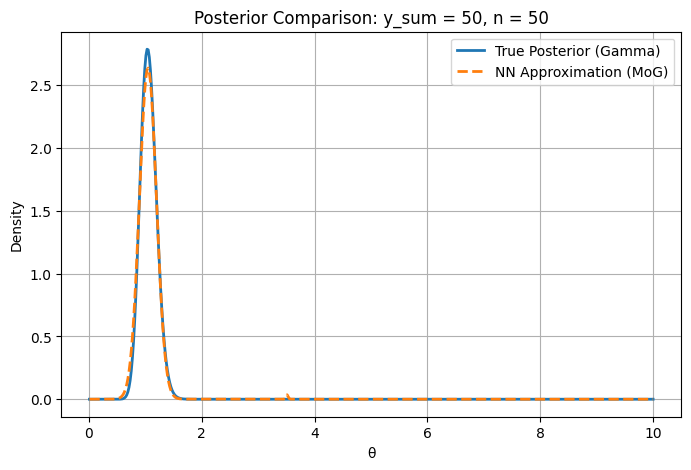

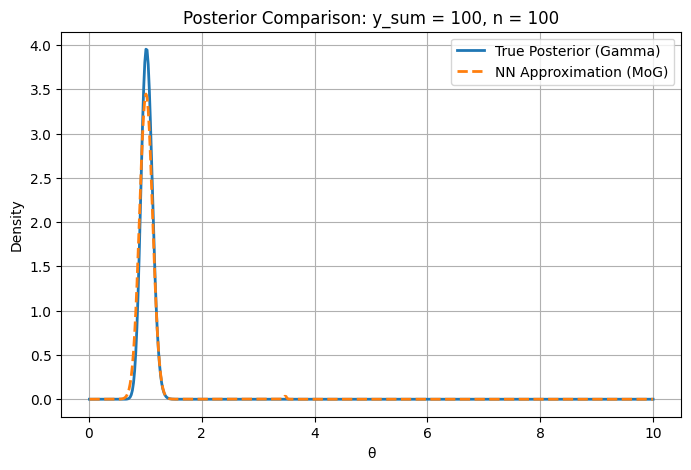

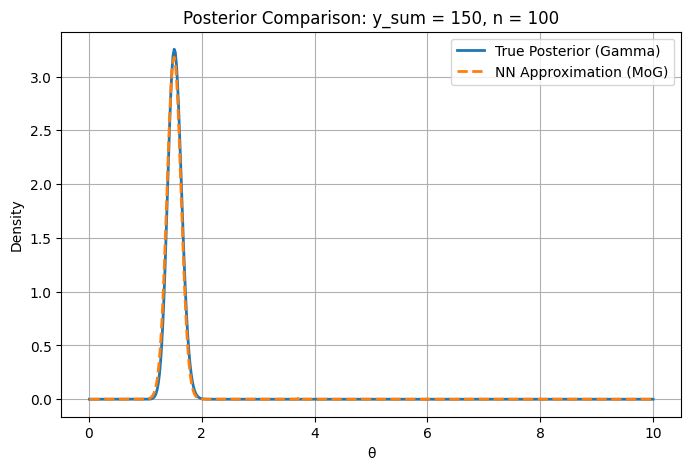

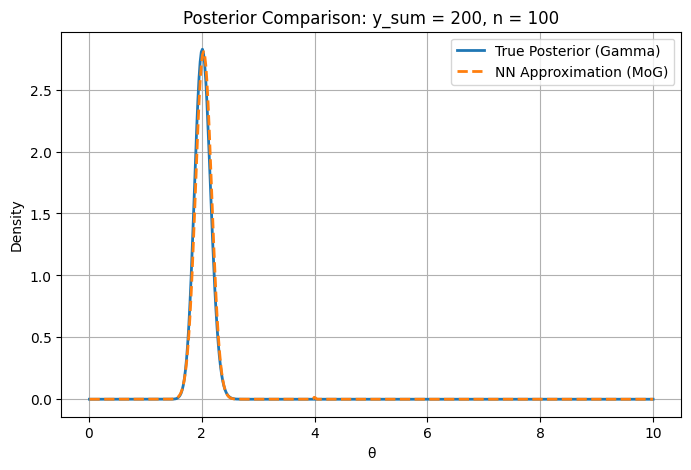

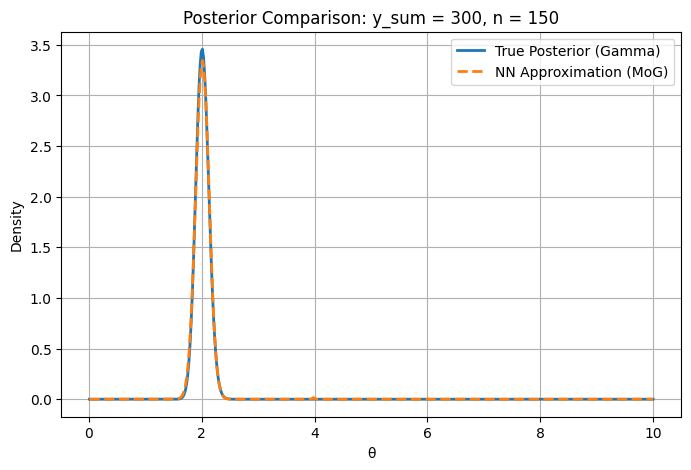

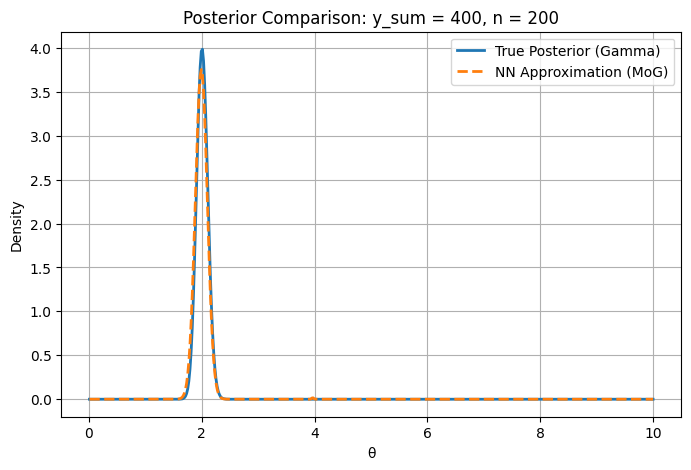

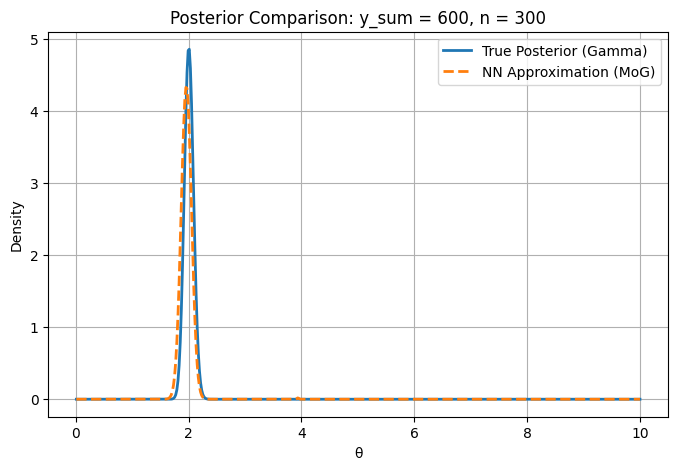

In [1]:
import random
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma

# Set random seed
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Gamma prior parameters
alpha = 4
beta_prior = 1
M = 500  # Simulation samples

# Simulate training data
n_values = list(range(10, 100, 10))  # From n = 10 to 90
df_final = pd.DataFrame()

for n in n_values:
    theta_samples = np.random.gamma(shape=alpha, scale=1 / beta_prior, size=M)
    y_sum_samples = [np.sum(np.random.poisson(lam=theta, size=n)) for theta in theta_samples]
    df = pd.DataFrame({
        'theta': theta_samples,
        'y_sum': y_sum_samples,
        'n': n
    })
    df_final = pd.concat([df_final, df], ignore_index=True)

# Prepare training pairs
unique_pairs = df_final[['y_sum', 'n']].drop_duplicates().reset_index(drop=True)
theta_lists = [
    df_final[(df_final['y_sum'] == row['y_sum']) & (df_final['n'] == row['n'])]['theta'].values
    for _, row in unique_pairs.iterrows()
]

# Mixture Density Network
class MixtureDensityNN(nn.Module):
    def __init__(self, K=3):
        super().__init__()
        self.K = K
        self.backbone = nn.Sequential(
            nn.Linear(3, 32), nn.Tanh(),
            nn.Linear(32, 16), nn.Tanh()
            
        )
        self.logits_head = nn.Linear(16, K)
        self.mu_head = nn.Linear(16, K)
        self.scale_head = nn.Sequential(
            nn.Linear(16, K),
            nn.Softplus()  # Ensure std > 0
        )

    def forward(self, x):
        h = self.backbone(x)
        logits = self.logits_head(h)
        weights = torch.softmax(logits, dim=-1)
        mu = self.mu_head(h)
        std = self.scale_head(h)
        return weights, mu, std

# Loss: negative log likelihood of Gaussian mixture
def mixture_log_likelihood(theta_vals, weights, mu, std):
    theta = theta_vals.expand(-1, mu.shape[1])
    log_probs = -0.5 * (torch.log(2 * torch.tensor(np.pi)) + 2 * torch.log(std) + ((theta - mu) ** 2) / (std ** 2))
    log_weighted = torch.log(weights + 1e-8) + log_probs
    log_sum_exp = torch.logsumexp(log_weighted, dim=1)
    return -log_sum_exp.mean()

# Normalize inputs
model = MixtureDensityNN(K=3)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training
for epoch in range(1000):
    model.train()
    total_loss = 0.0
    for (y_val, n_val), theta_arr in zip(unique_pairs.values, theta_lists):
        if len(theta_arr) < 2 or np.var(theta_arr) == 0:
            continue
        x_feat = [y_val / n_val, np.log1p(y_val), np.log1p(n_val)]
        x_input = torch.tensor([x_feat], dtype=torch.float32)
        theta_vals = torch.tensor(theta_arr, dtype=torch.float32).view(-1, 1)
        weights, mu, std = model(x_input)
        loss = mixture_log_likelihood(theta_vals, weights, mu, std)
        total_loss += loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss.item():.5f}")

# Evaluation
test_cases = [
    (50, 50),
    (100, 100),
    (150, 100),
    (200, 100),
    (300, 150),
    (400, 200),
    (600, 300)
]

theta_range = np.linspace(0.01, 10.0, 500)

for y_obs, n_obs in test_cases:
    x_feat = [y_obs / n_obs, np.log1p(y_obs), np.log1p(n_obs)]
    x_test = torch.tensor([x_feat], dtype=torch.float32)

    with torch.no_grad():
        weights, mu, std = model(x_test)

    approx_pdf = np.zeros_like(theta_range)
    for k in range(weights.shape[1]):
        pi_k = weights[0, k].item()
        mu_k = mu[0, k].item()
        std_k = std[0, k].item()
        approx_pdf += pi_k * norm.pdf(theta_range, loc=mu_k, scale=std_k)

    alpha_post = alpha + y_obs
    beta_post = beta_prior + n_obs
    true_pdf = gamma.pdf(theta_range, a=alpha_post, scale=1 / beta_post)

    plt.figure(figsize=(8, 5))
    plt.plot(theta_range, true_pdf, label="True Posterior (Gamma)", lw=2)
    plt.plot(theta_range, approx_pdf, label="NN Approximation (MoG)", lw=2, linestyle="--")
    plt.title(f"Posterior Comparison: y_sum = {y_obs}, n = {n_obs}")
    plt.xlabel("θ")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()


Evaluate with more pairs of (y_sum, n)

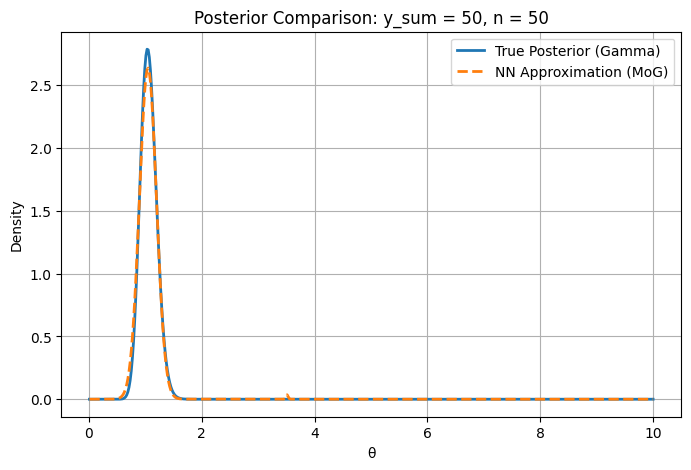

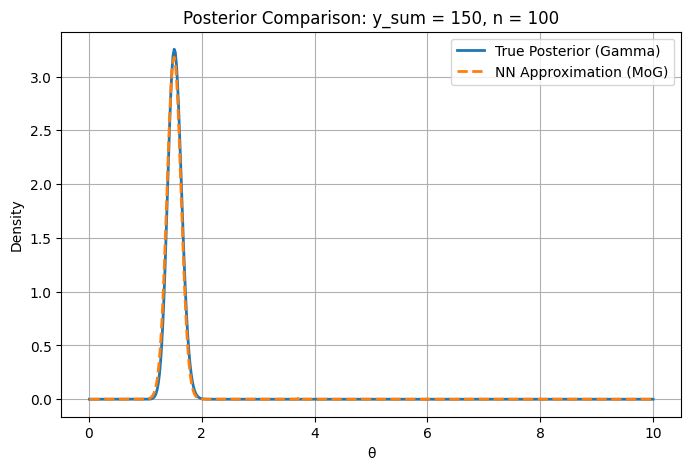

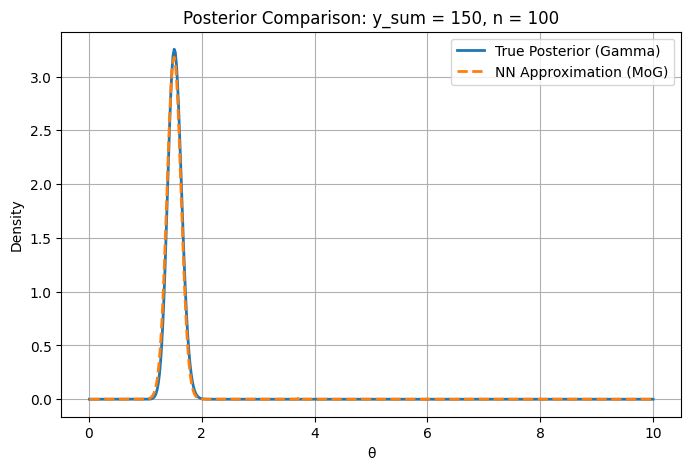

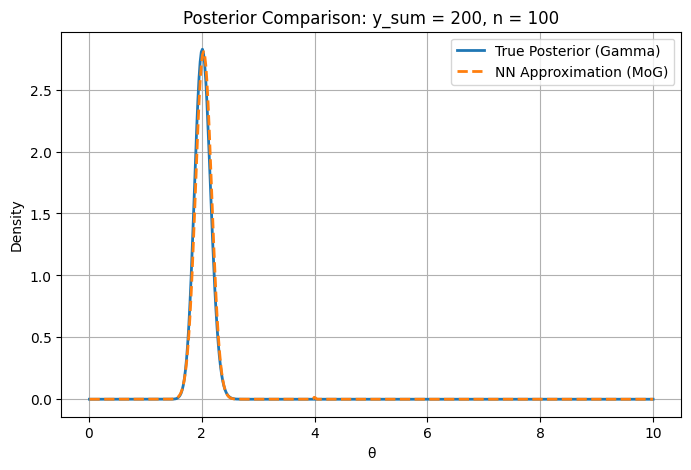

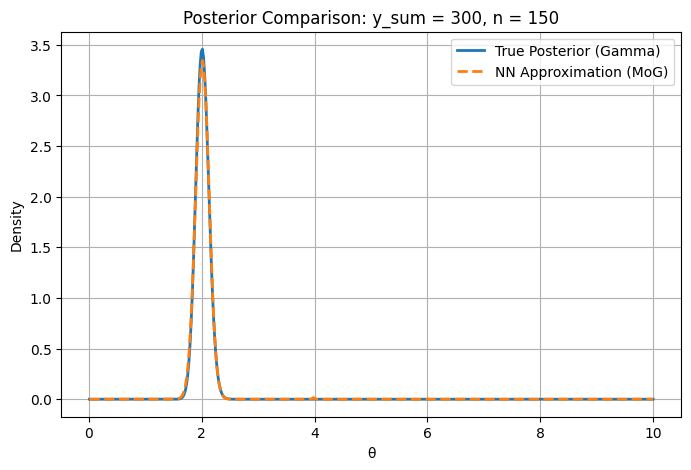

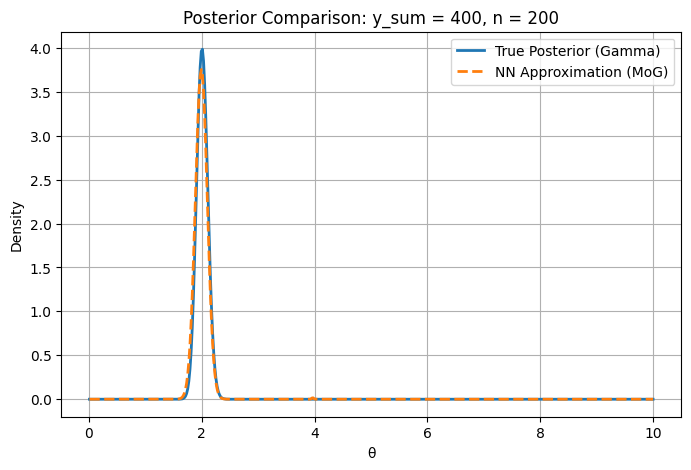

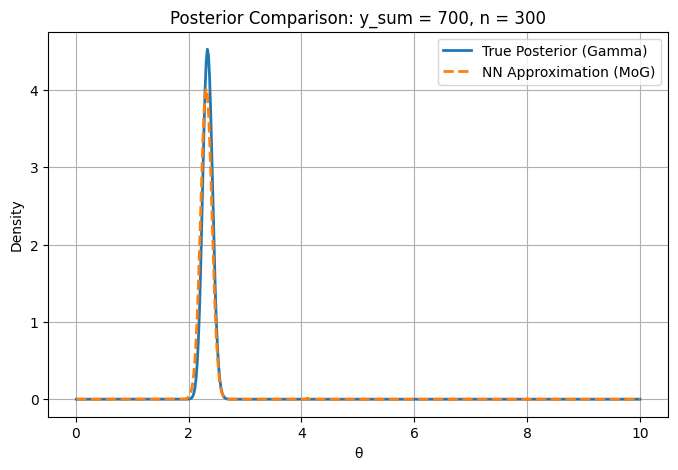

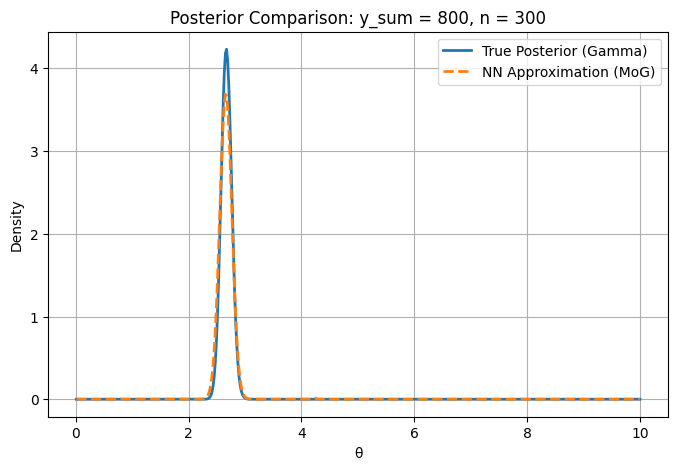

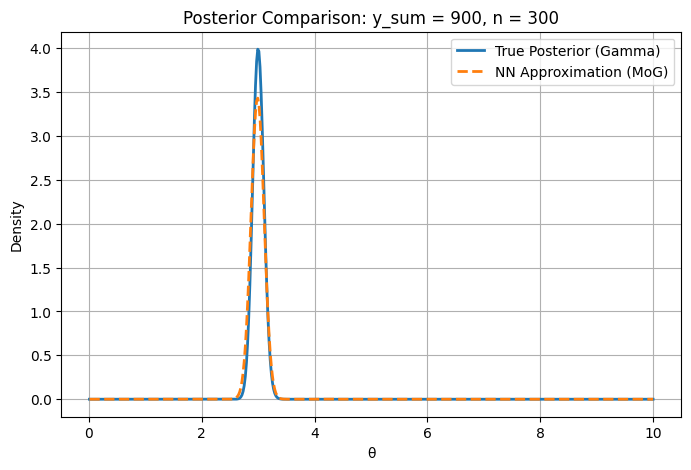

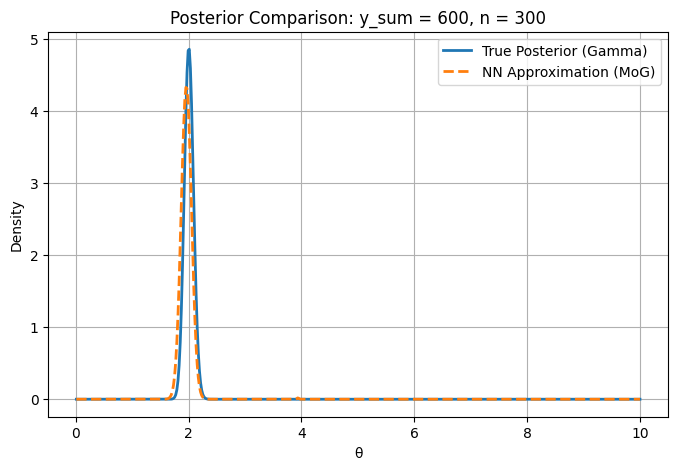

In [10]:

# Evaluation
test_cases = [
    (50, 50),
    (150, 100),
    (150, 100),
    (200, 100),
    (300, 150),
    (400, 200),
    (700, 300),
    (800, 300),
    (900, 300),
    (600, 300)
]

theta_range = np.linspace(0.01, 10.0, 500)

for y_obs, n_obs in test_cases:
    x_feat = [y_obs / n_obs, np.log1p(y_obs), np.log1p(n_obs)]
    x_test = torch.tensor([x_feat], dtype=torch.float32)

    with torch.no_grad():
        weights, mu, std = model(x_test)

    approx_pdf = np.zeros_like(theta_range)
    for k in range(weights.shape[1]):
        pi_k = weights[0, k].item()
        mu_k = mu[0, k].item()
        std_k = std[0, k].item()
        approx_pdf += pi_k * norm.pdf(theta_range, loc=mu_k, scale=std_k)

    alpha_post = alpha + y_obs
    beta_post = beta_prior + n_obs
    true_pdf = gamma.pdf(theta_range, a=alpha_post, scale=1 / beta_post)

    plt.figure(figsize=(8, 5))
    plt.plot(theta_range, true_pdf, label="True Posterior (Gamma)", lw=2)
    plt.plot(theta_range, approx_pdf, label="NN Approximation (MoG)", lw=2, linestyle="--")
    plt.title(f"Posterior Comparison: y_sum = {y_obs}, n = {n_obs}")
    plt.xlabel("θ")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()
